In [202]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [203]:
bikes = pd.read_csv('data/bikes_clean.csv')
bikes.head()

,Start Time,Stop Time,Start Station ID,Start Station Name,End Station ID,End Station Name,Bike ID,User Type,Birth Year,Age,Age Groups,Trip Duration,Trip_Duration_in_min,Month,Season,Temperature,Weekday
0,1/1/2017 1:47,1/1/2017 1:58,3183,Exchange Place,3203,Hamilton Park,26167,Subscriber,1993,28,25-34,639,11,1,Winter,10,Sunday
1,1/1/2017 1:47,1/1/2017 1:58,3183,Exchange Place,3203,Hamilton Park,26167,Subscriber,1993,28,25-34,639,11,1,Winter,10,Sunday
2,1/1/2017 1:56,1/1/2017 2:00,3186,Grove St PATH,3270,Jersey & 6th St,24604,Subscriber,1970,51,45-54,258,4,1,Winter,10,Sunday
3,1/1/2017 2:12,1/1/2017 2:23,3270,Jersey & 6th St,3206,Hilltop,24641,Subscriber,1978,43,35-44,663,11,1,Winter,10,Sunday
4,1/1/2017 2:22,1/1/2017 2:31,3212,Christ Hospital,3225,Baldwin at Montgomery,24520,Subscriber,1987,34,25-34,535,9,1,Winter,10,Sunday


### Data Preprocessing

In [204]:
# Data Preprocessing
bikes['Start Time'] = pd.to_datetime(bikes['Start Time'])
bikes['Stop Time'] = pd.to_datetime(bikes['Stop Time'])
# Calculate trip duration in minutes
bikes['Trip Duration'] = (bikes['Stop Time'] - bikes['Start Time']).dt.total_seconds() / 60

# Now you can aggregate this data daily (or at another frequency) for forecasting
daily_duration = bikes.groupby(bikes['Start Time'].dt.date)['Trip Duration'].sum().reset_index(name='Total Duration')

# Prepare the data for Prophet
prophet_data = daily_duration.rename(columns={'Start Time': 'ds', 'Total Duration': 'y'})

### Detect and Remove Outliers

In [205]:
def detect_and_remove_outliers(data, columns):
    for col in columns:
        # Calculate the lower and upper bounds for outliers
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Remove outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Columns to check for outliers
columns_to_check = ['y']

# Apply the function to remove outliers
prophet_data = detect_and_remove_outliers(prophet_data, columns_to_check)

### Model Training

14:34:19 - cmdstanpy - INFO - Chain [1] start processing
14:34:19 - cmdstanpy - INFO - Chain [1] done processing


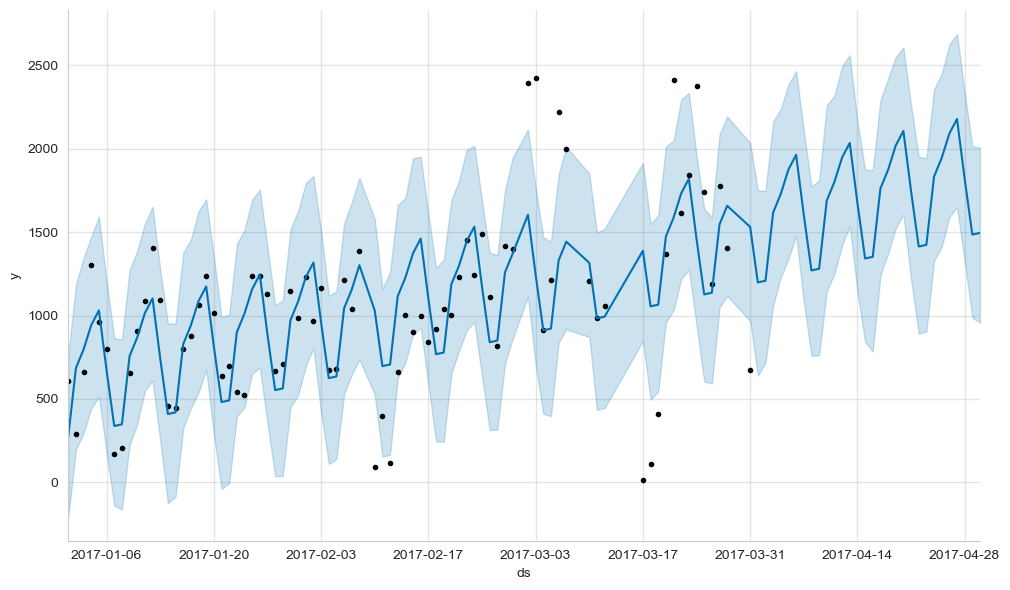

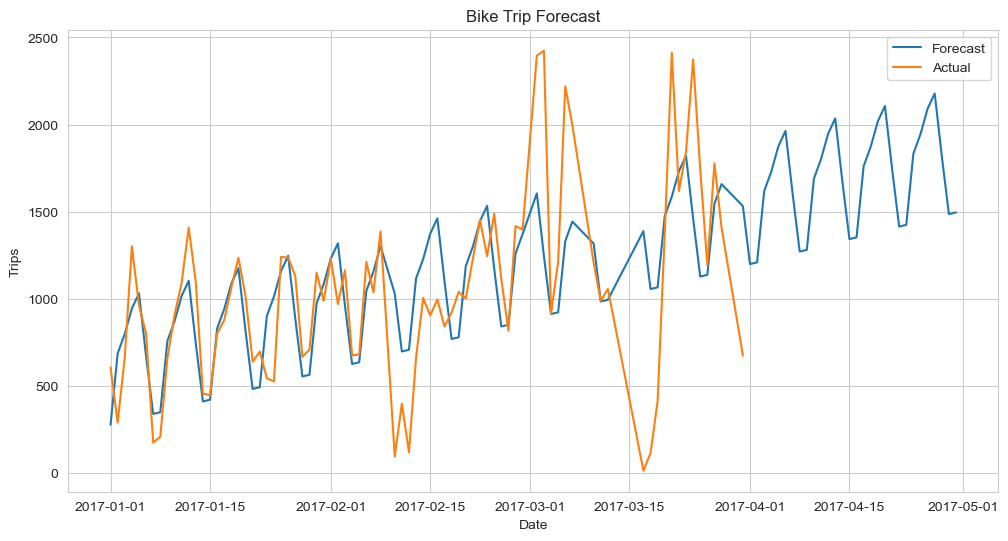

In [216]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Model Training with disabled yearly seasonality
model = Prophet(yearly_seasonality=False)
model.fit(prophet_data)

# Forecasting for a shorter period
forecast_period = 30  # Example: Forecast for the next month
future = model.make_future_dataframe(periods=forecast_period)
forecast = model.predict(future)

# Visualizing Forecast
fig = model.plot(forecast)
ax = fig.gca()
ax.set_xlim(daily_trips['ds'].min(), forecast['ds'].max())

# Adding Seaborn styling
sns.set_style("whitegrid")
sns.despine()

# Plot the forecast with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="ds", y="yhat", data=forecast, label="Forecast")
sns.lineplot(x="ds", y="y", data=prophet_data, label="Actual")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.title("Bike Trip Forecast")
plt.legend()
plt.show()

### Model Evaluation

Mean Absolute Error (MAE): 280.53092143319725
Mean Squared Error (MSE): 165573.48682369437
Root Mean Squared Error (RMSE): 406.9072213953623


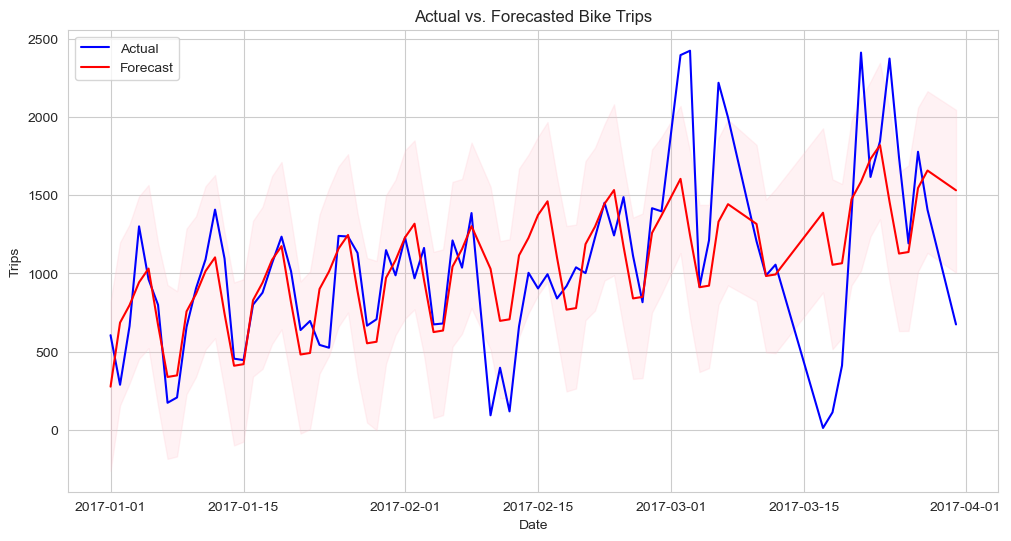

In [207]:
# Ensure forecast DataFrame only includes dates present in prophet_data
if 'ds' in forecast.columns and 'yhat' in forecast.columns:
    forecast_filtered = forecast[forecast['ds'].isin(prophet_data['ds'])]

    # Calculate evaluation metrics
    mae = mean_absolute_error(prophet_data['y'], forecast_filtered['yhat'])
    mse = mean_squared_error(prophet_data['y'], forecast_filtered['yhat'])
    rmse = np.sqrt(mse)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Visual Inspection
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
    ax.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Forecast', color='red')
    if 'yhat_lower' in forecast.columns and 'yhat_upper' in forecast.columns:
        ax.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='pink', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Trips')
    ax.set_title('Actual vs. Forecasted Bike Trips')
    ax.legend()
    plt.show()
else:
    print("The forecast DataFrame does not have the required columns.")

### Cross-Validation

14:21:25 - cmdstanpy - INFO - Chain [1] start processing
14:21:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0  1 days  379210.858334  615.800989  396.071871  9.913177  0.099349   
1  2 days  254050.105404  504.033834  358.404701  0.989935  0.237274   
2  3 days  220776.973538  469.869103  377.683453  0.831355  0.349965   
3  4 days  120997.846971  347.847448  294.081423  0.297917  0.241544   
4  5 days  291317.299272  539.738177  410.918299  0.341034  0.285048   

      smape  coverage  
0  0.416978  0.533333  
1  0.378654  0.538462  
2  0.420726  0.416667  
3  0.285081  0.461538  
4  0.332452  0.416667  
Mean Absolute Error (MAE): 269.50967923951004
Mean Squared Error (MSE): 161179.36925622987
Root Mean Squared Error (RMSE): 401.47150491190513
Mean Absolute Percentage Error (MAPE): 1.952810029778511


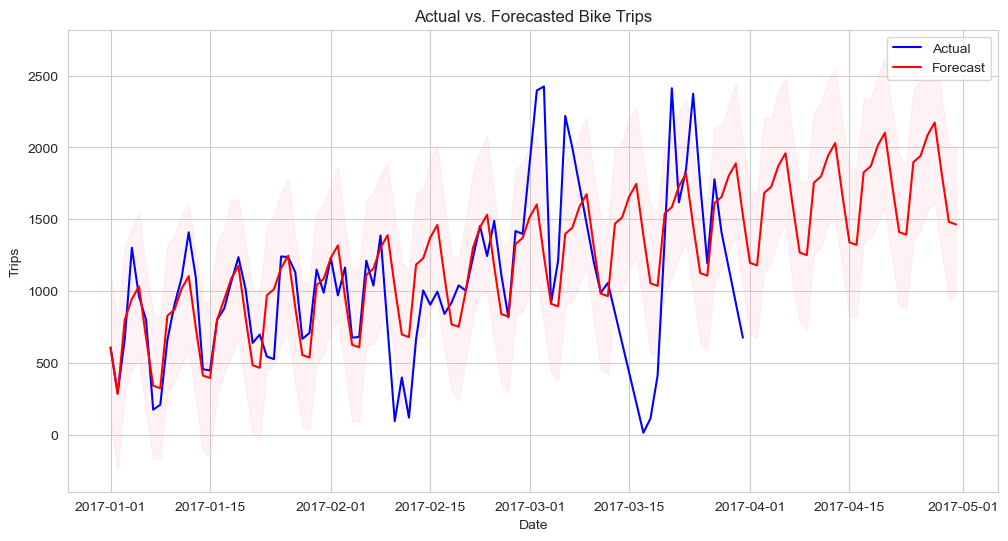

In [208]:
# Adjust the forecasting period
future = prophet_data['ds'].max() + pd.DateOffset(days=30)  # Forecast for the next month
future = pd.DataFrame({'ds': pd.date_range(start=prophet_data['ds'].min(), end=future, freq='D')})

# Initialize the Prophet model and fit it to the data
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(prophet_data)

# Generate the forecast
forecast = model.predict(future)

# Implement a rolling window cross-validation
rolling_cv = cross_validation(model, initial='10 days', period='5 days', horizon='5 days', parallel="processes")
rolling_p = performance_metrics(rolling_cv)
print(rolling_p)

# Filter the forecast to the period covered by the actual data
forecast_filtered = forecast[forecast['ds'].isin(prophet_data['ds'])]

# Ensure that the actual data and forecast have the same number of samples
if len(prophet_data) == len(forecast_filtered):
    # Calculate evaluation metrics
    mae = mean_absolute_error(prophet_data['y'], forecast_filtered['yhat'])
    mse = mean_squared_error(prophet_data['y'], forecast_filtered['yhat'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(prophet_data['y'], forecast_filtered['yhat'])

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Percentage Error (MAPE):", mape)
else:
    print("The actual data and forecast have different numbers of samples.")

# Visual Inspection
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Trips')
ax.set_title('Actual vs. Forecasted Bike Trips')
ax.legend()
plt.show()

### Add Custom Seasonality and Holidays

14:22:58 - cmdstanpy - INFO - Chain [1] start processing
14:22:59 - cmdstanpy - INFO - Chain [1] done processing


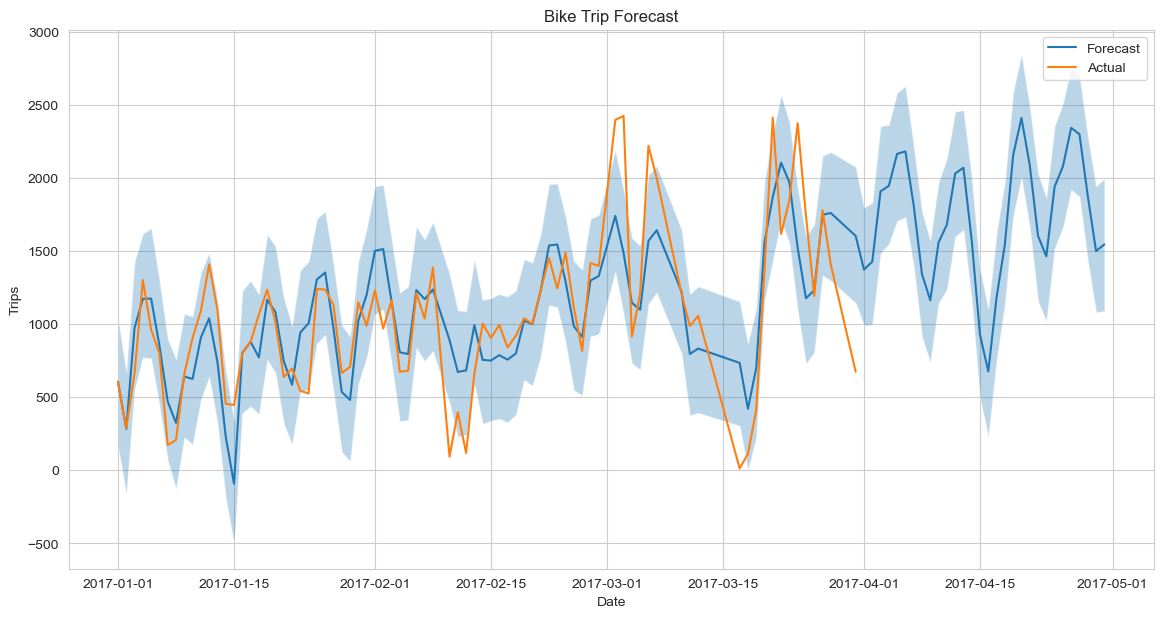

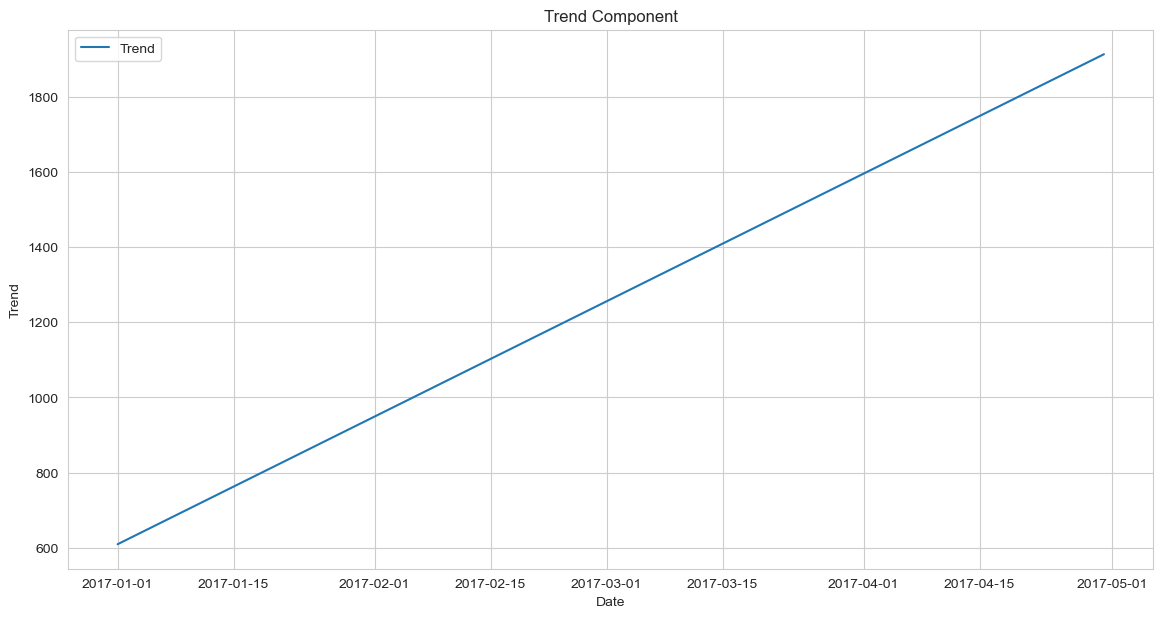

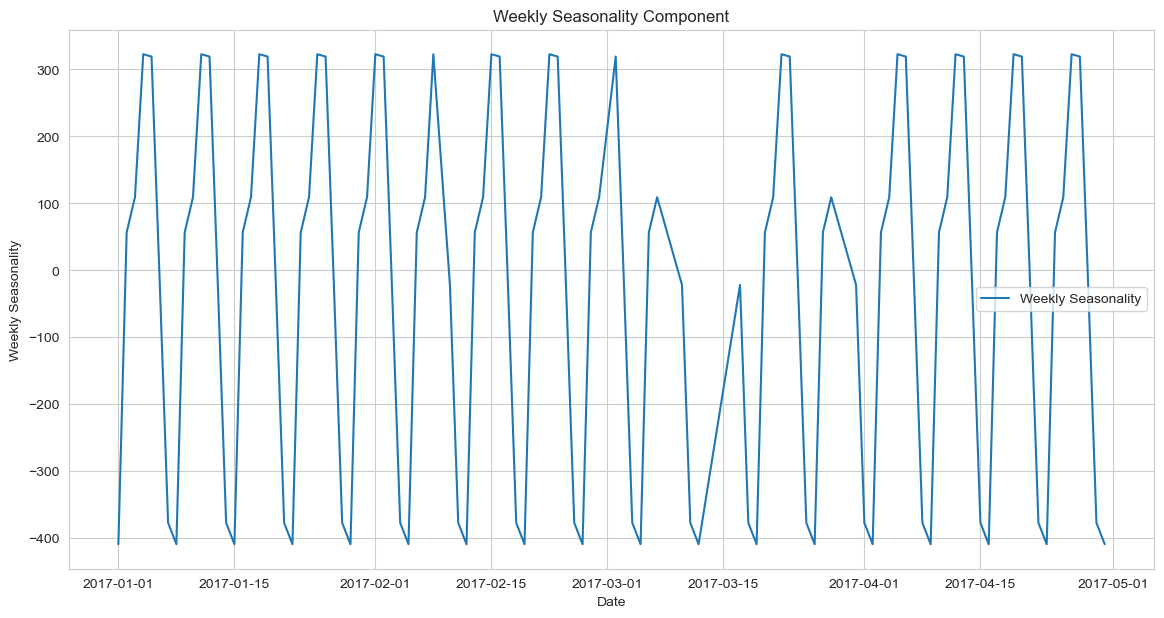

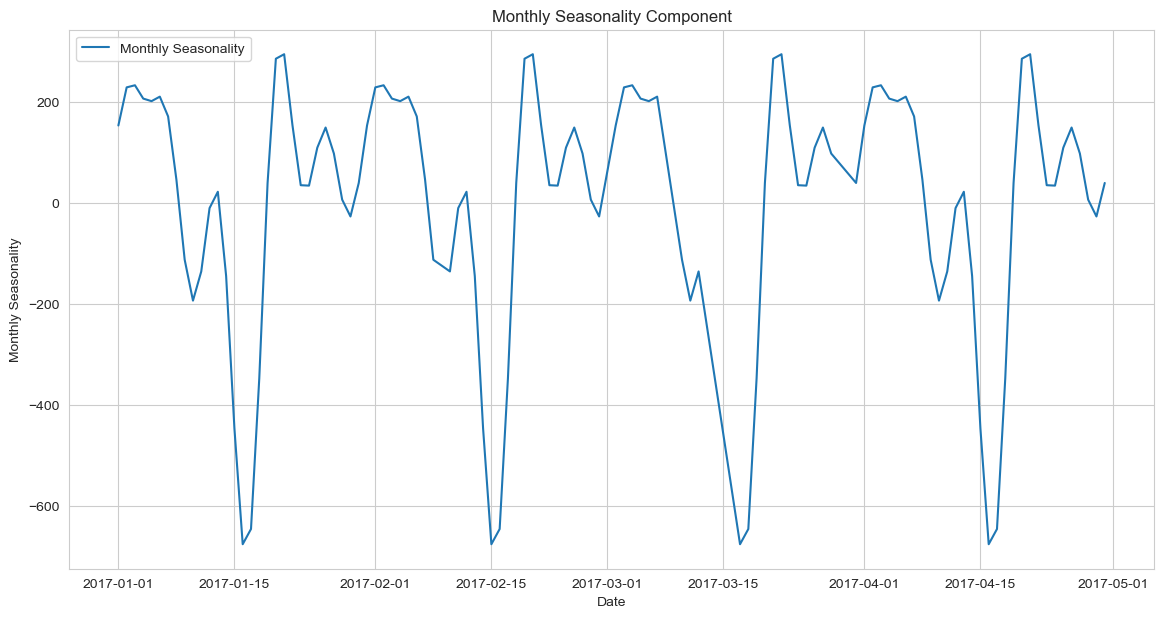

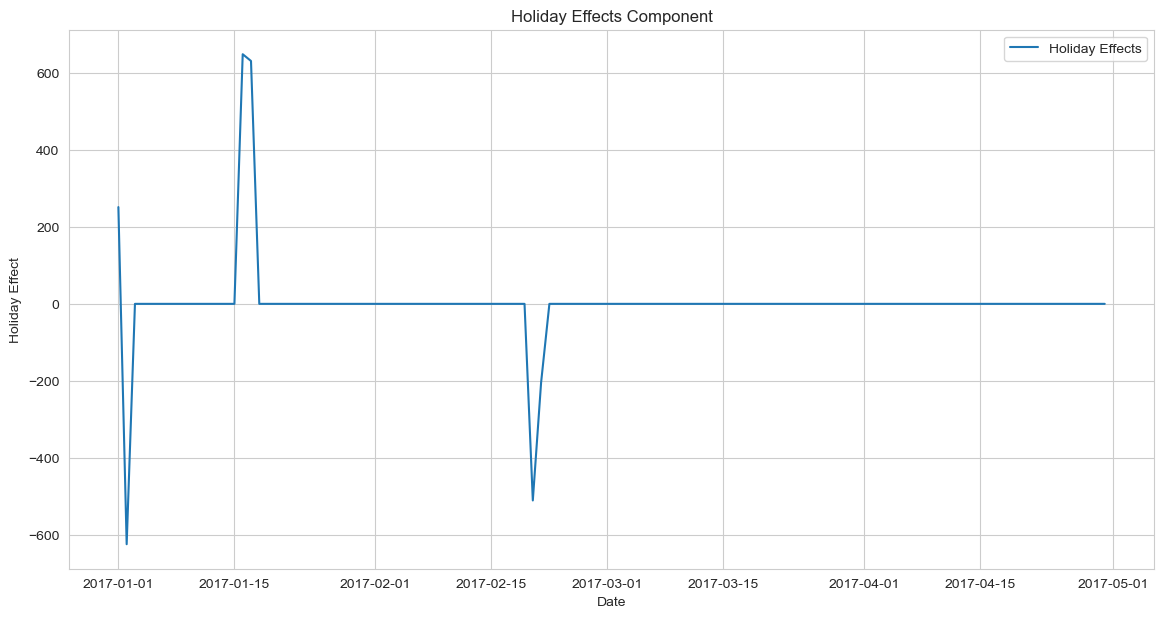

In [210]:
# Initialize the model with custom seasonality and holidays
holidays = pd.DataFrame({
    'holiday': ['New Year\'s Day', 'Martin Luther King Jr. Day', 'Washington\'s Birthday'],
    'ds': pd.to_datetime(['2017-01-01', '2017-01-16', '2017-02-20']),
    'lower_window': 0,
    'upper_window': 1,
})

model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays
)

# Add custom seasonality
model.add_seasonality(name='monthly', period=30, fourier_order=5)

# Retrain the model with the new settings
model.fit(prophet_data)

# Make future dataframe for predictions
future = model.make_future_dataframe(periods=30)  # Adjust the periods as needed

# Include the holidays in the future dataframe
future = model.setup_dataframe(future)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x='ds', y='yhat', data=forecast, label='Forecast')
sns.lineplot(x='ds', y='y', data=prophet_data, ax=ax, label='Actual')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
ax.set(title='Bike Trip Forecast', xlabel='Date', ylabel='Trips')
plt.legend()
plt.show()

# Trend component
plt.figure(figsize=(14, 7))
sns.lineplot(x='ds', y='trend', data=forecast, label='Trend')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.show()

# Seasonality components
# Weekly
plt.figure(figsize=(14, 7))
sns.lineplot(x='ds', y='weekly', data=forecast, label='Weekly Seasonality')
plt.title('Weekly Seasonality Component')
plt.xlabel('Date')
plt.ylabel('Weekly Seasonality')
plt.show()

# Monthly seasonality component
plt.figure(figsize=(14, 7))
sns.lineplot(x='ds', y='monthly', data=forecast, label='Monthly Seasonality')
plt.title('Monthly Seasonality Component')
plt.xlabel('Date')
plt.ylabel('Monthly Seasonality')
plt.show()

# Holiday effects component
plt.figure(figsize=(14, 7))
sns.lineplot(x='ds', y='holidays', data=forecast, label='Holiday Effects')
plt.title('Holiday Effects Component')
plt.xlabel('Date')
plt.ylabel('Holiday Effect')
plt.show()

### Cross-validation

  0%|          | 0/5 [00:00<?, ?it/s]

14:33:04 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing
14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:06 - cmdstanpy - INFO - Chain [1] done processing
14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing
14:33:08 - cmdstanpy - INFO - Chain [1] done processing


   horizon            mse        rmse         mae       mape     mdape  \
0   2 days  236014.207457  485.812935  403.832351   7.530434  0.322319   
1   3 days  157668.598489  397.075054  344.342818   0.865715  0.246730   
2   4 days  111377.920547  333.733308  279.256083   0.288806  0.218785   
3   5 days  116318.197556  341.054538  305.343199   0.243787  0.202927   
4   6 days  441848.023053  664.716498  582.354153   1.990950  0.338363   
5   7 days  540692.189365  735.317747  562.252097   1.121489  0.325493   
6   8 days  669455.027482  818.202315  624.615886   2.362012  0.457421   
7   9 days  699496.577231  836.359120  711.450650   1.624416  0.368638   
8  10 days  652936.475000  808.044847  699.624146   0.568816  0.474128   
9  11 days  557231.437929  746.479362  639.589615  16.721754  0.477111   
10 12 days  275756.633683  525.125350  414.730764   7.568933  0.236988   
11 13 days  106807.015793  326.813427  240.516190   0.876584  0.097368   
12 14 days   45139.336126  212.460199 

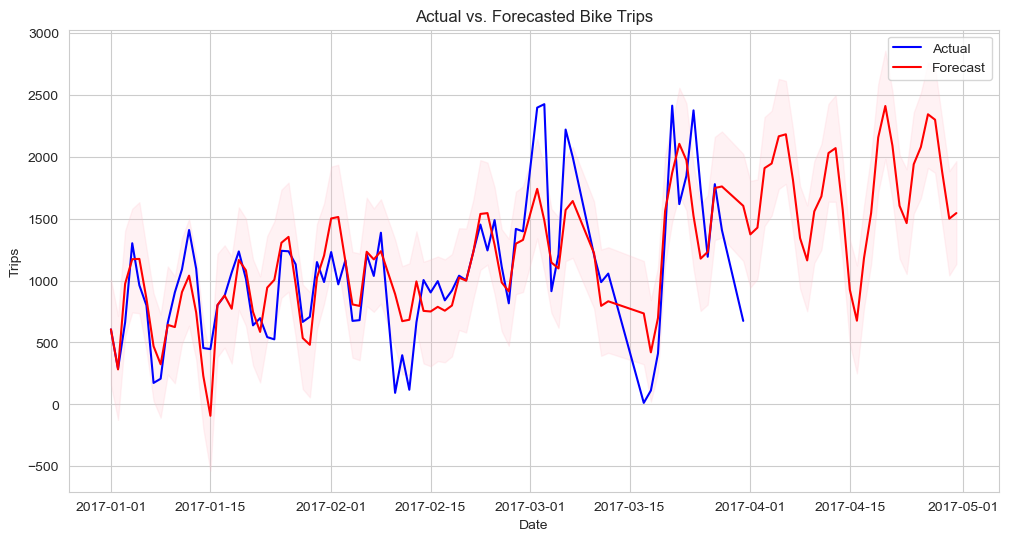

In [214]:
# Make future predictions
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Perform cross-validation
df_cv = cross_validation(model, initial='30 days', period='10 days', horizon='15 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)
print(df_p)

# Evaluate the model
actuals = prophet_data[prophet_data['ds'].isin(forecast['ds'])]

# Ensure that the actual data and forecast have the same number of samples
if len(prophet_data) == len(forecast):
    # Calculate evaluation metrics
    mae = mean_absolute_error(prophet_data['y'], forecast['yhat'])
    mse = mean_squared_error(prophet_data['y'], forecast['yhat'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(prophet_data['y'], forecast['yhat'])

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Percentage Error (MAPE):", mape)
else:
    print("The actual data and forecast have different numbers of samples.")

# Visualize the forecast
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(prophet_data['ds'], prophet_data['y'], label='Actual', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
# Check if 'yhat_lower' and 'yhat_upper' exist before plotting
if 'yhat_lower' in forecast.columns and 'yhat_upper' in forecast.columns:
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Trips')
ax.set_title('Actual vs. Forecasted Bike Trips')
ax.legend()
plt.show()

### Save the model

In [220]:
import pickle

# Save the model to a file
with open('time_series_model.pkl', 'wb') as f:
    pickle.dump(model, f)